[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Risultati regressione TEN.MI ~ UNG:
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 2.969e+04
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        21:00:41   Log-Likelihood:                -7483.2
No. Observations:                1820   AIC:                         1.497e+04
Df Residuals:                    1818   BIC:                         1.498e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6

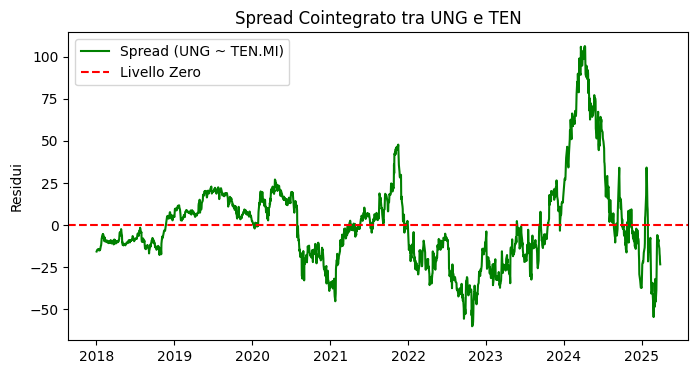

In [2]:
####################
##### CAPITOLO 2.5.3
####################


import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import adfuller

TEN = yf.download('AAPL', start="2018-01-01", end="2025-3-30")
UNG = yf.download('MSFT', start="2018-01-01", end="2025-3-30")


# Estrazione dei prezzi di chiusura per ciascun ticker
price_TEN = TEN['Close']
price_UNG = UNG['Close']


# Allineamento degli indici temporali per confrontare i periodi comuni
common_index = price_TEN.index.intersection(price_UNG.index)
price_TEN = price_TEN.reindex(common_index).dropna()
price_UNG = price_UNG.reindex(common_index).dropna()

# Garantiamo l'allineamento finale sui medesimi indici
price_TEN = price_TEN.loc[common_index]
price_UNG = price_UNG.loc[common_index]

#####################################################
# Regressione 1: TEN.MI (variabile dipendente) ~ UNG (variabile esplicativa)
#####################################################
# Aggiungiamo un'intercetta a price_UNG e stimiamo il modello OLS
model_TEN_on_UNG = sm.OLS(price_TEN, sm.add_constant(price_UNG)).fit()
print("Risultati regressione TEN.MI ~ UNG:")
print(model_TEN_on_UNG.summary())

#####################################################
# Regressione 2: UNG (variabile dipendente) ~ TEN.MI (variabile esplicativa)
#####################################################
# Aggiungiamo un'intercetta a price_TEN e stimiamo il modello OLS
model_UNG_on_TEN = sm.OLS(price_UNG, sm.add_constant(price_TEN)).fit()
print("\nRisultati regressione UNG ~ TEN.MI:")
print(model_UNG_on_TEN.summary())


# Calcolo dei residui e test ADF per la stazionarietà dello spread

# Modello TEN.MI ~ UNG
resid_TEN_on_UNG = model_TEN_on_UNG.resid
adf_result_TEN_on_UNG = adfuller(resid_TEN_on_UNG)
print("\nTest ADF per i residui della regressione TEN.MI ~ UNG:")
print("Statistic ADF:", adf_result_TEN_on_UNG[0])
print("p-value:", adf_result_TEN_on_UNG[1])

# Modello UNG ~ TEN.MI
resid_UNG_on_TEN = model_UNG_on_TEN.resid
adf_result_UNG_on_TEN = adfuller(resid_UNG_on_TEN)
print("\nTest ADF per i residui della regressione UNG ~ TEN.MI:")
print("Statistic ADF:", adf_result_UNG_on_TEN[0])
print("p-value:", adf_result_UNG_on_TEN[1])

#####################################################
# Scelta del modello con spread cointegrato migliore e visualizzazione grafica

plt.figure(figsize=(8,4 ))
plt.plot(common_index, resid_UNG_on_TEN, label='Spread (UNG ~ TEN.MI)', color='green')

# Linea orizzontale a zero per evidenziare lo spread attorno al livello di equilibrio
plt.axhline(y=0, color='red', linestyle='--', label='Livello Zero')
plt.title('Spread Cointegrato tra UNG e TEN')
plt.ylabel('Residui')
plt.legend()
plt.show()





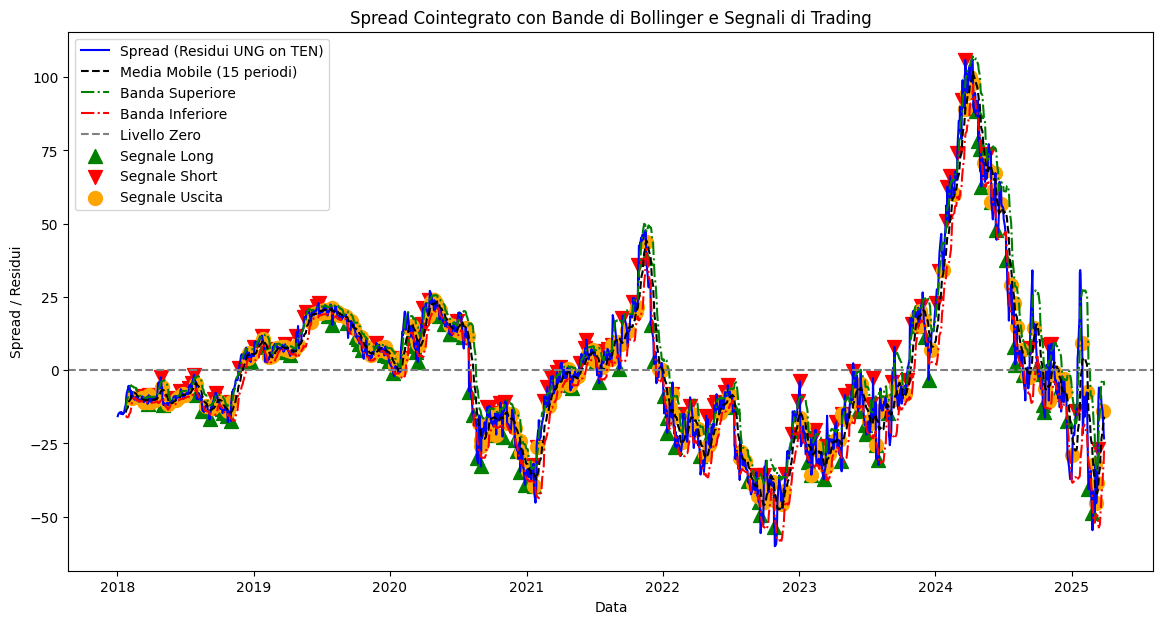

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Supponiamo che "residui_UNG_on_TEN" sia una Series di Pandas con indice datetime
# Ad esempio:
# residui_UNG_on_TEN = pd.Series(..., index=pd.date_range(start='2024-01-21', periods=..., freq='D'))

# Parametri per le Bande di Bollinger
lookback = 15
multiplier = 1.2

# Calcolo della media mobile e della deviazione standard su 15 periodi
rolling_mean = resid_UNG_on_TEN.rolling(window=lookback).mean()
rolling_std  = resid_UNG_on_TEN.rolling(window=lookback).std()

# Calcolo delle bande superiore e inferiore
upper_band = rolling_mean + multiplier * rolling_std
lower_band = rolling_mean - multiplier * rolling_std

# Calcolo dello z-score della serie degli spread
# Lo z-score indica quanto il valore attuale si discosta (in termini di deviazioni standard) dalla media mobile
zscore = (resid_UNG_on_TEN - rolling_mean) / rolling_std

# Identificazione dei segnali tramite crossover dello z-score:
# - Entrata long: quando lo z-score scende al di sotto di -1.5 (da un valore precedente superiore a -1.5)
# - Entrata short: quando lo z-score sale sopra 1.5 (da un valore precedente inferiore a 1.5)
# - Uscita: quando lo z-score ritorna all’interno del range [-0.5, 0.5] (passando dalla zona estrema)

# Notare che con .shift(1) verifichiamo il passaggio da un periodo al successivo.
long_entry = ((zscore.shift(1) > -1.5) & (zscore <= -1.5))
short_entry = ((zscore.shift(1) < 1.5) & (zscore >= 1.5))
exit_signal = (((zscore.shift(1) < -0.5) & (zscore >= -0.5)) |
               ((zscore.shift(1) > 0.5) & (zscore <= 0.5)))

# Creazione del grafico
plt.figure(figsize=(14, 7))

# Plot dello spread (residui)
plt.plot(resid_UNG_on_TEN.index, resid_UNG_on_TEN, label='Spread (Residui UNG on TEN)', color='blue')

# Plot della media mobile e delle bande di Bollinger
plt.plot(rolling_mean.index, rolling_mean, label='Media Mobile (15 periodi)', color='black', linestyle='--')
plt.plot(upper_band.index, upper_band, label='Banda Superiore ', color='green', linestyle='-.')
plt.plot(lower_band.index, lower_band, label='Banda Inferiore ', color='red', linestyle='-.')

# Linea orizzontale a livello zero
plt.axhline(y=0, color='grey', linestyle='--', label='Livello Zero')

# Aggiunta dei segnali:
# - Marker triangolari (^) per i long entry (segnalati in verde)
plt.scatter(resid_UNG_on_TEN.index[long_entry], resid_UNG_on_TEN[long_entry],
            color='green', marker='^', s=100, label='Segnale Long')

# - Marker triangolari (v) per i short entry (segnalati in rosso)
plt.scatter(resid_UNG_on_TEN.index[short_entry], resid_UNG_on_TEN[short_entry],
            color='red', marker='v', s=100, label='Segnale Short')

# - Marker circolari per i segnali di uscita (segnalati in arancione)
plt.scatter(resid_UNG_on_TEN.index[exit_signal], resid_UNG_on_TEN[exit_signal],
            color='orange', marker='o', s=100, label='Segnale Uscita')

# Titolo e etichette
plt.title('Spread Cointegrato con Bande di Bollinger e Segnali di Trading')
plt.xlabel('Data')
plt.ylabel('Spread / Residui')
plt.legend()
plt.show()
